In [158]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import json
from scipy.stats import weibull_min
import numpy as np
import pandas as pd
plt.style.use('seaborn')
%matplotlib inline

#custom
from scripts.utils import convert_to_lifetimes

In [181]:
from scipy.stats import uniform

In [4]:
data = json.load(open('data/data.json', 'r'))

In [67]:
from lifelines import WeibullFitter, KaplanMeierFitter
from scipy.stats import kstest, cramervonmises





#make all in one function (portable to a script)
def compute_plausibility(T, E=None, method='ks'):
    """
        Compute plausibility score that observed data are sampled from the
        chosen null distribution (Weubull in our case). The score is computed
        based on the Kolmogorov-Smirnov or Cramer-von-Mises statistics and ranged from -inf to 1,
        where 1 means full correspondence between data and null distribution;
        and 0 - the opposite.
        Vars:
        T::1d array - survival times vector;
        E::1d array - (optional) censoring vector
        stat::bool - whether return statistics or not along with
                        plausibility score
        returns -> float: plausibility score
    """
    kmf = KaplanMeierFitter().fit(T,)
    wf = WeibullFitter().fit(T, E)
    l, k = wf.lambda_, wf.rho_
    weibull_cdf = lambda x: 1 - np.exp(-(x / l)**k) 
    
    if method == 'ks':
        st, pval = kstest(T, weibull_cdf)
        plausibility = 1 / st
        return st, pval
    elif method == 'cramer':
        tmp = cramervonmises(T, weibull_cdf)
        st, pval = tmp.statistic, tmp.pvalue
        plausibility = 1 / st
        return st, pval
    elif method == 'brier':
        EDF = kmf.cumulative_density_['KM_estimate']
        CDF = weibull_cdf(kmf.timeline) 
        plausibility = 1 - np.mean((EDF - CDF) ** 2)
        st, pval = None, None
        return plausibility
    elif method == 'r2':
        EDF = kmf.cumulative_density_['KM_estimate']
        CDF = weibull_cdf(kmf.timeline) 
        plausibility = np.corrcoef(EDF, CDF)[0,1]**2
        st, pval = None, None
        return plausibility
    #elif method == 'concordance':   
    else:
        raise NotImplementedError()

In [149]:
for name, experiment in data.items():
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 
    #wf = WeibullFitter().fit(T)
    #st, pval = compute_plausibility(T, E=None, method='ks')

(array([ 4.,  7.,  7., 13.,  8.,  7.,  9., 11.,  6.,  9.,  4.,  4.,  1.,
         4.,  1.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.01417548, 0.02140988, 0.02864429, 0.03587869, 0.04311309,
        0.0503475 , 0.0575819 , 0.06481631, 0.07205071, 0.07928511,
        0.08651952, 0.09375392, 0.10098832, 0.10822273, 0.11545713,
        0.12269154, 0.12992594, 0.13716034, 0.14439475, 0.15162915,
        0.15886355, 0.16609796, 0.17333236, 0.18056677, 0.18780117,
        0.19503557, 0.20226998, 0.20950438, 0.21673878, 0.22397319,
        0.23120759]),
 <BarContainer object of 30 artists>)

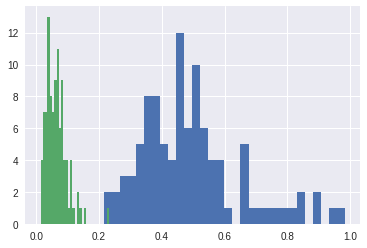

In [74]:


plauf = []
plaut = []
for _ in range(100):
    T = np.random.uniform(1, 100, 200)
    st, pval = compute_plausibility(T, E=None, method='cramer')
    plauf.append(st)
    T = weibull_dummy_control = weibull_min.rvs(2, loc=0, scale=5, size=50)
    st, pval = compute_plausibility(T, E=None, method='cramer')
    plaut.append(st)
    # wf = WeibullFitter().fit(T)
    # kmf = KaplanMeierFitter().fit(T)
    # l, k = wf.lambda_, wf.rho_
    # weibull_cdf = lambda x: 1 - np.exp(-(x / l)**k) 
    # S = 1 - weibull_cdf(kmf.timeline) 
    # pl = concordance_index(T, wf.predict(T))
   
plt.hist(plauf, bins=30)
plt.hist(plaut, bins=30)

In [218]:
def compute_plausibility_score(T, E=None, method='ks'):
    # define target distribution
    wf = WeibullFitter().fit(T, E)
    l, k = wf.lambda_, wf.rho_
    weibull_cdf = lambda x: 1 - np.exp(-(x / l)**k)
    # define anti-distribution
    a, b = np.min(T), np.max(T) #uniform boundaries 
    uniform_cdf = lambda x: np.minimum((x - a) / (b - a), 1.)
    # test with some `method`
    if method=='ks':
        _, pval1 = kstest(T, weibull_cdf)
        _, pval2 = kstest(T, uniform_cdf)
    elif method=='cramer':
        tmp1 = cramervonmises(T, weibull_cdf)
        _, pval1 = tmp1.statistic, tmp1.pvalue
        tmp2 = cramervonmises(T, uniform_cdf)
        _, pval2 = tmp2.statistic, tmp2.pvalue
    pl = np.log10(pval1 / pval2)
    return pl

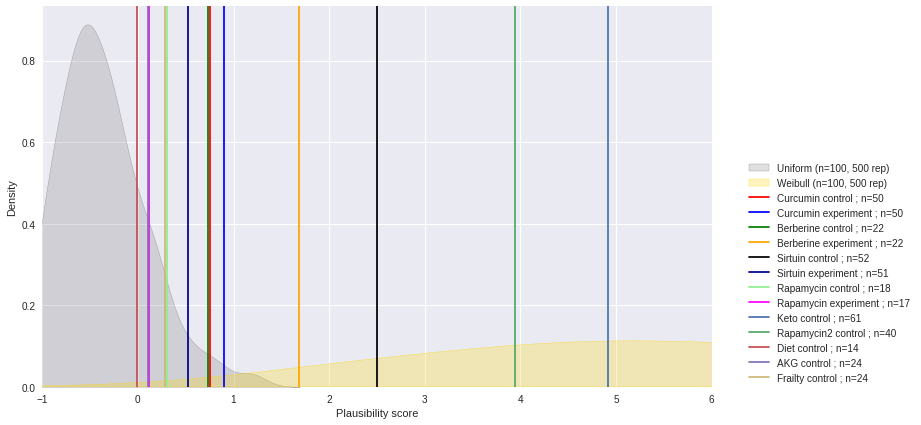

In [220]:
# method = 'ks'
# plauf = []
# plaut = []
# for _ in range(500):
#     T = np.random.uniform(1, 100, 100)
#     pl_f = compute_plausibility_score(T, E=None, method=method)
#     plauf.append(pl_f)

#     T = weibull_min.rvs(2, loc=0, scale=5, size=100)
#     pl_t = compute_plausibility_score(T, E=None, method=method)
#     plaut.append(pl_t)

plt.figure(figsize=(12, 7))
sns.kdeplot(plauf, label = 'Uniform (n=100, 500 rep)', color='grey', shade=True)
sns.kdeplot(plaut, label = 'Weibull (n=100, 500 rep)', color='gold', shade=True)

colors = ['r', 'b', 'g', 'orange', 'black', 'darkblue', 'lightgreen', 'magenta', 
          '#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']
for i, (name, experiment) in enumerate(data.items()):
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n) 
    pl = compute_plausibility_score(T, E=None, method=method)
    plt.axvline(pl, label=name + f' ; n={n}', color=colors[i])
plt.legend(loc=[1.05, 0.0]);
plt.xlim([-1, 6])
plt.xlabel('Plausibility score');


In [221]:
np.mean(plauf), np.mean(plaut)

(-0.3785637943185557, 7.042772851989516)

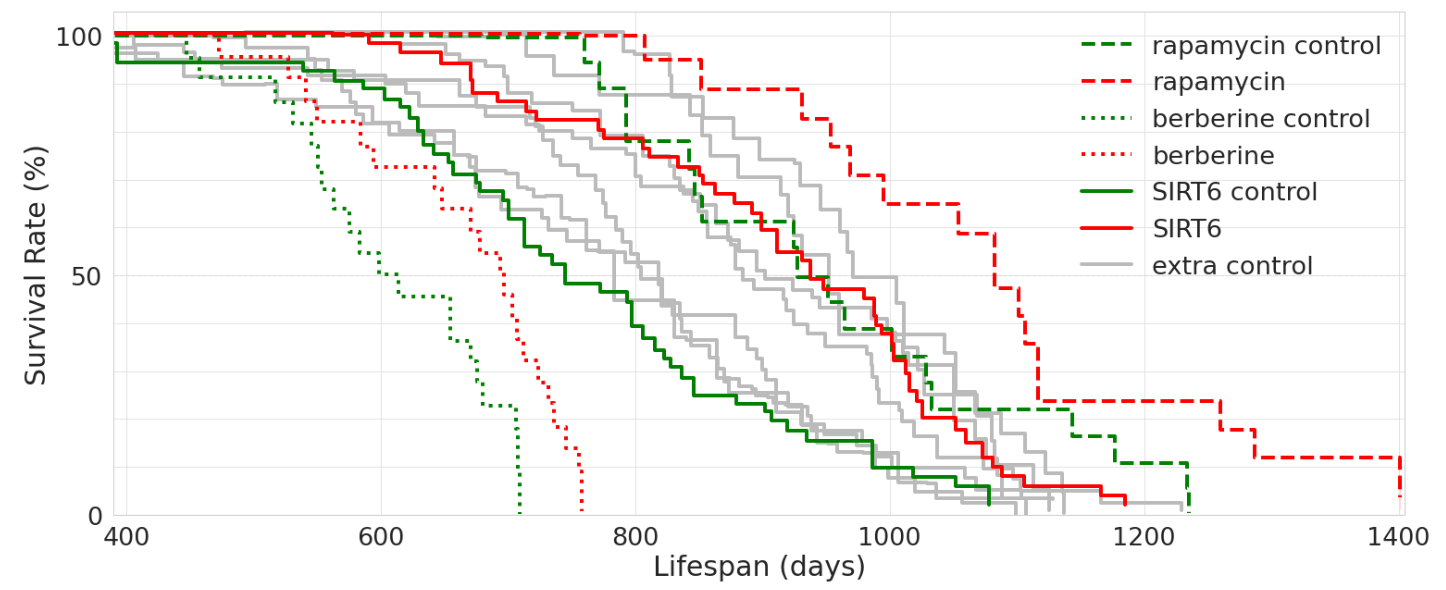